In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/Research1_code/

In [ ]:
cd mnist/CNN-2

In [4]:
import numpy as np, joblib
import sys, os, random
import matplotlib.pyplot as plt
import pickle, gzip
from tqdm import tqdm,tqdm_notebook
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [7]:
batch_size = 128
seed_num = 81

# For reproducibility when you run the file with .py
torch.cuda.is_available()
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)
torch.backends.cudnn.benchmark = True

torch.backends.cudnn.deterministic =True

In [5]:
# Data Augmentation 
train_transform = transforms.Compose([transforms.RandomRotation(30), transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.1307,],[0.3081,])])
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.1307,],[0.3081,])])

# Splitting the training and test datasets
train_data = datasets.MNIST(os.getcwd(), train=True,
                              download=True, transform=train_transform)
test_data = datasets.MNIST(os.getcwd(), train=False,
                             download=True, transform=test_transform)


In [8]:
# Split the training set indices into training and validation set indices using 80:20 ratio
np.random.seed(seed_num)
len_trainset = len(train_data)
index_list = list(range(len_trainset))
np.random.shuffle(index_list)
split_index = 50000
train_indices, valid_indices =  index_list[:split_index], index_list[split_index:]

# Creating Samplers for training and validation set using the indices
np.random.seed(seed_num)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

torch.manual_seed(seed_num)

train_iterator = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_iterator = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_iterator = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [9]:
# CNN Model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0, bias= True)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0, bias= True)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 5 * 5, 10,bias= True) 
    
    def forward(self, x):
        # Set 1
        out = F.max_pool2d(F.relu(self.cnn1(x)),2)
        
        # Set 2
        out = F.max_pool2d(F.relu(self.cnn2(out)),2) 
        
        # Flatten
        out = out.view(out.size(0), -1)

        # Dense
        out = self.fc1(out)
        
        return out

In [10]:
torch.manual_seed(seed_num)
unit=128

# Summary
model = CNNModel()
print("Model:\n",model)

Model:
 CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)


In [11]:
# Layer names
layer_name = [n for n, p in model.named_parameters()]
layer_name

['cnn1.weight',
 'cnn1.bias',
 'cnn2.weight',
 'cnn2.bias',
 'fc1.weight',
 'fc1.bias']

In [12]:
# Loading the weights of ternary model 
model = torch.load('CNN_2_quant.pt')
model = model.cuda()
print("Loading weights done !")

# Total number of ternary weights (+w, -w)
totalParams = 0
for i in layer_name:
  print(i,(model.state_dict()[i] !=0).sum())
  totalParams +=  (model.state_dict()[i] !=0).sum()
    
print("Total Parameters:",totalParams, '\n')

Loading weights done !
cnn1.weight tensor(104, device='cuda:0')
cnn1.bias tensor(13, device='cuda:0')
cnn2.weight tensor(436, device='cuda:0')
cnn2.bias tensor(28, device='cuda:0')
fc1.weight tensor(780, device='cuda:0')
fc1.bias tensor(9, device='cuda:0')
Total Parameters: tensor(1370, device='cuda:0') 



In [13]:
# Model's performance on test set

correct_count, all_count = 0, 0
for images,labels in test_iterator:
      for image,label in zip(images,labels):

        if torch.cuda.is_available():
            img = image.cuda()
            lab = label.cuda()
            img = img[None,].type('torch.cuda.FloatTensor')

        with torch.no_grad():
            output_ = model(img) 

        pred_label = output_.argmax()

        if(pred_label.item()==lab.item()):
          correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Test Accuracy =", (correct_count/(all_count)))


Number Of Images Tested = 10000

Model Test Accuracy = 0.893


In [14]:
# For each layer, model's ternary weights
state_dict = model.state_dict()

layer_distinct_weights = {}

for i in layer_name:
  imd = torch.unique(model.state_dict()[i])
  print(i+ ' hidden layer dimension', model.state_dict()[i].shape)
  print("Unique values of weight in "+ i+ " th hidden layer : ", imd)
  layer_distinct_weights[i] = imd.cpu().numpy().tolist()
  print()


cnn1.weight hidden layer dimension torch.Size([16, 1, 3, 3])
Unique values of weight in cnn1.weight th hidden layer :  tensor([-1.,  0.,  1.], device='cuda:0')

cnn1.bias hidden layer dimension torch.Size([16])
Unique values of weight in cnn1.bias th hidden layer :  tensor([-1.,  0.,  1.], device='cuda:0')

cnn2.weight hidden layer dimension torch.Size([32, 16, 3, 3])
Unique values of weight in cnn2.weight th hidden layer :  tensor([-1.,  0.,  1.], device='cuda:0')

cnn2.bias hidden layer dimension torch.Size([32])
Unique values of weight in cnn2.bias th hidden layer :  tensor([-1.,  0.,  1.], device='cuda:0')

fc1.weight hidden layer dimension torch.Size([10, 800])
Unique values of weight in fc1.weight th hidden layer :  tensor([-1.,  0.,  1.], device='cuda:0')

fc1.bias hidden layer dimension torch.Size([10])
Unique values of weight in fc1.bias th hidden layer :  tensor([-1.,  0.,  1.], device='cuda:0')



In [15]:
# Single seed normal distribution
np.random.seed(seed_num)
corr_images1 = []

for i in range(4000): 
  corr_images1.append(np.random.randn(1,28,28))

corr_images1 = np.array(corr_images1)
corr_images1.shape

(4000, 1, 28, 28)

In [16]:
# Structured Patterns

np.random.seed(seed_num)

corr_images2 = []
a = np.identity(28) * np.random.randn(28)
corr_images2.append(a)
b = np.fliplr(a.copy()) * np.random.randn(28)
corr_images2.append(b)
c = (a+b).copy() * np.random.randn(28)
corr_images2.append(c)

# To apply [1,1] , [0,1], [1,0]
cp_file = [a,b,c]

# To apply randn
a1,b1,c1 = a.copy(), b.copy(), c.copy()
cp_file1 = [a1, b1, c1]

files = [cp_file, cp_file1]

for i in range(6000):
    
    np.random.seed(i)
    choose = np.random.randint(0,2)

    # Picking row and column indices randomly
    r_idx = np.random.randint(0,28)
    c_idx = np.random.randint(0,28)

    if choose == 0:
        
        # Selecting file
        file = files[0]
        
        imd_img = file[np.random.randint(0,3)].copy()
        
        imd_img1 = file[np.random.randint(0,3)]
        
        opt =[[1,1] , [0,1], [1,0]]
        
        if np.random.randint(0,2) == 0:
        
            imd_img[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img)

            imd_img[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img)

        else:
            imd_img1[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img1)

            imd_img1[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) 
            corr_images2.append(imd_img1)
            

    else:
        
        # Selecting file
        file = files[1]
        
        imd_img = file[np.random.randint(0,3)].copy()
        
        imd_img1 = file[np.random.randint(0,3)]
        
        opt =[[1,1] , [0,1], [1,0]]
        
        if np.random.randint(0,2) == 0:
        
            imd_img[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img)

            imd_img[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img)

        else:
            imd_img1[r_idx,:] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img1)

            imd_img1[:,c_idx] = np.array(opt[np.random.randint(0,3)] *14) * np.random.randn(28)
            corr_images2.append(imd_img1)
    
corr_images2 = np.array(corr_images2).reshape(len(corr_images2),1,28,28)

In [17]:
corr_images2 = np.unique(corr_images2, axis=0)
len(corr_images2)

3099

In [18]:
# Augmentation on structured images
check_transform2 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(35), transforms.RandomHorizontalFlip(),
                                      transforms.Normalize([0.1307,],[0.3081,])]) 
    
corr_images2_ = []
for img in corr_images2:
    corr_images2_.append(check_transform2(img).permute([1,0,2]).numpy())

corr_images2 = np.array(corr_images2_)
corr_images2.shape

(3099, 1, 28, 28)

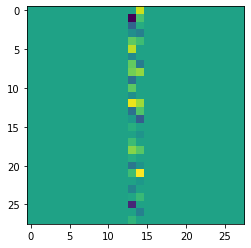

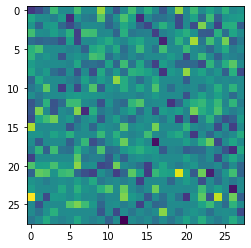

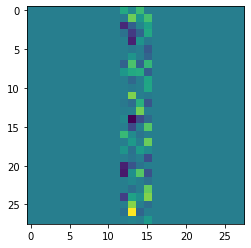

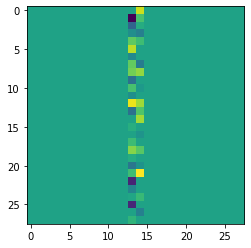

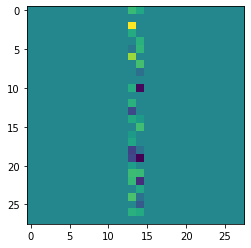

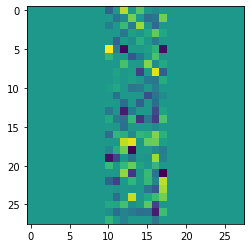

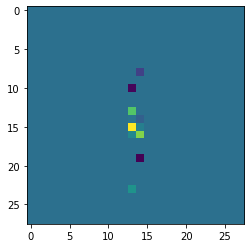

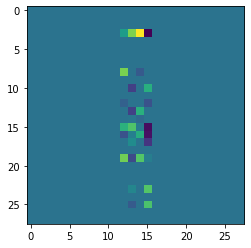

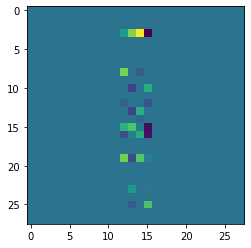

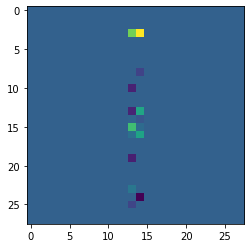

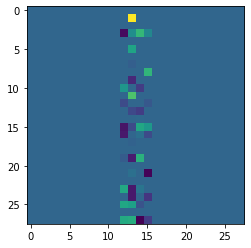

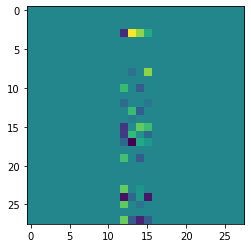

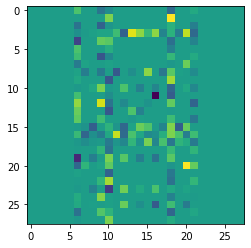

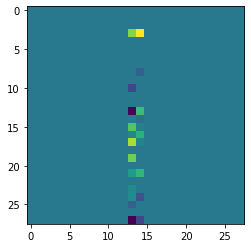

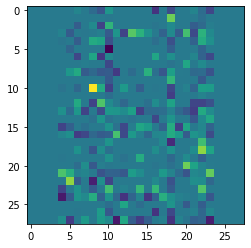

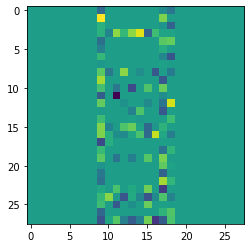

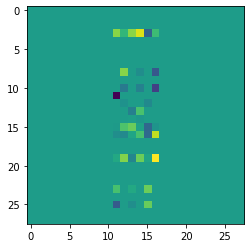

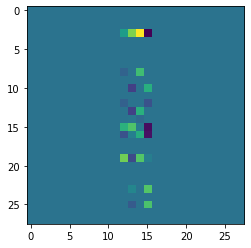

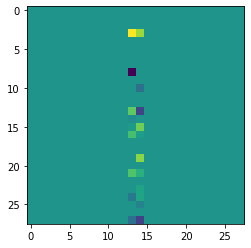

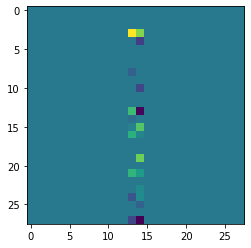

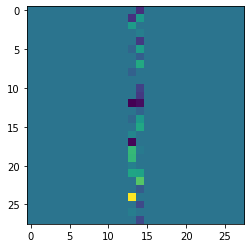

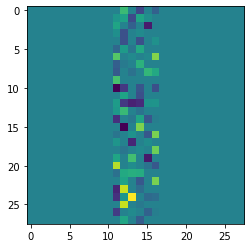

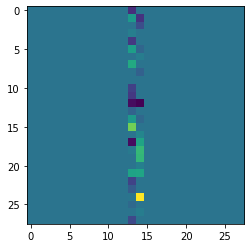

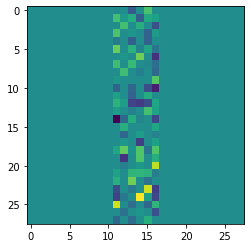

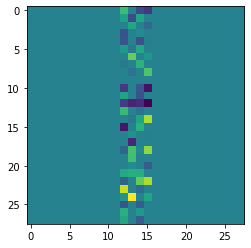

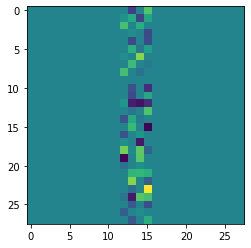

In [19]:
# Plotting some structured images
for i in range(2,28):
    plt.imshow(corr_images2[i].reshape((28,28)))
    plt.show()

In [20]:
#############
# Pixel taking randomly from 8 bits (0-255) to generate images

np.random.seed(seed_num)
corr_images1_ = []

for i in range(3000):
  corr_images1_.append(np.random.randint(0, 256, (1,28,28)).astype('float')/255.)


check_transform1 = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(45), transforms.RandomHorizontalFlip(),
                                      transforms.Normalize([0.1307,],[0.3081,])]) 
 

corr_images_ = []
for img in corr_images1_:
    corr_images_.append(check_transform1(img).permute([1,0,2]).numpy())

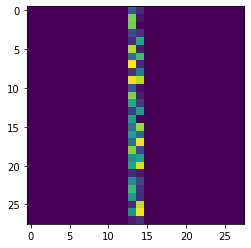

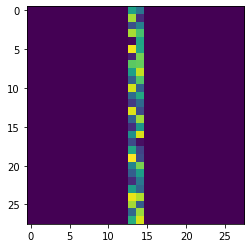

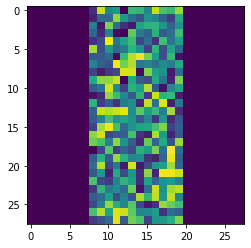

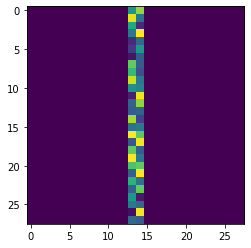

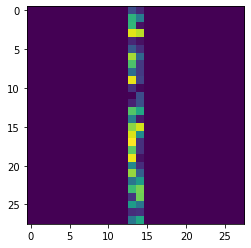

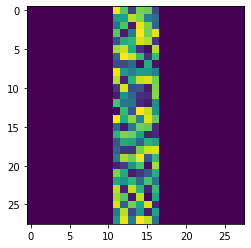

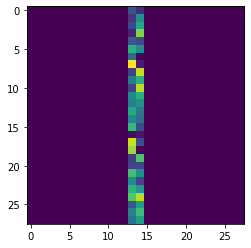

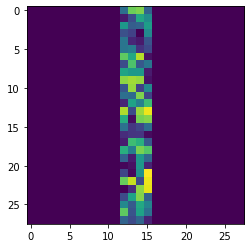

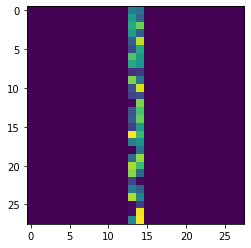

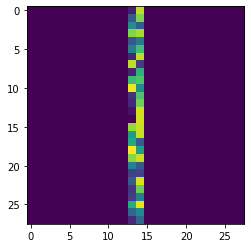

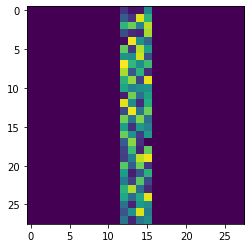

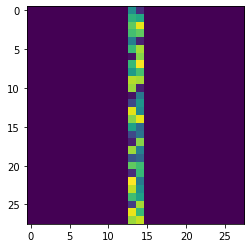

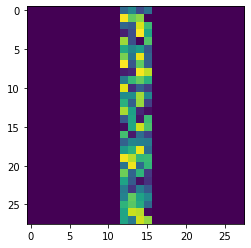

In [21]:
for i in range(15,28):
    plt.imshow(corr_images_[i].reshape((28,28)))
    plt.show()

In [22]:
corr_images3 = np.array(corr_images_)

In [23]:
# Normal dist + Structured + Random Pixel
corr_images = np.concatenate([corr_images1, corr_images2, corr_images3])[:10000]
corr_images.shape

(10000, 1, 28, 28)

In [24]:
corr_images = torch.tensor(corr_images).type(torch.FloatTensor).to('cuda')

corr_label = []
check_label = []

model.eval()
for img in corr_images:
  img = img[None,].type('torch.cuda.FloatTensor')
  with torch.no_grad():
    pred = model(img).argmax()
  corr_label.append(pred)
  check_label.append(pred.item())

digit,count = np.unique(check_label, return_counts=True)

# Model's prediction on pseudorandom images
print("\nUnique digits : ",digit)

print("\n counts : ",count)


Unique digits :  [0 1 2 3 4 5 6 7 8 9]

 counts :  [  99 3142  500 1234 1403 1494   16   80 2028    4]


In [25]:
pos_neg_layerwise = {}

for i in layer_name:
  b = layer_distinct_weights[i]

  if len(b) == 3:
    neg, zero, pos = b
    pos_neg_layerwise[i] = {}
    pos_neg_layerwise[i]['pos'] = pos
    pos_neg_layerwise[i]['neg'] = neg
    
  elif len(b) == 2:
    un1, un2 = b

    if un2 == 0:
      neg, zero = b
      pos_neg_layerwise[i] = {}
      pos_neg_layerwise[i]['neg'] = neg
      
    elif un1 == 0:
      zero, pos = b
      pos_neg_layerwise[i] = {}
      pos_neg_layerwise[i]['pos'] = pos

    else:
      neg, pos = b
      pos_neg_layerwise[i] = {}
      pos_neg_layerwise[i]['pos'] = pos
      pos_neg_layerwise[i]['neg'] = neg

  else:
     un = b[0] 

     if un > 0:
       pos_neg_layerwise[i] = {}
       pos_neg_layerwise[i]['pos'] = un

     elif un < 0:
       pos_neg_layerwise[i] = {}
       pos_neg_layerwise[i]['neg'] = un

     else:
       pos_neg_layerwise[i] = {}
       pos_neg_layerwise[i]['zero'] = 0


In [26]:
layer_distinct_weights

{'cnn1.bias': [-1.0, 0.0, 1.0],
 'cnn1.weight': [-1.0, 0.0, 1.0],
 'cnn2.bias': [-1.0, 0.0, 1.0],
 'cnn2.weight': [-1.0, 0.0, 1.0],
 'fc1.bias': [-1.0, 0.0, 1.0],
 'fc1.weight': [-1.0, 0.0, 1.0]}

In [27]:
class PseudoData(Dataset):
    
    def __init__(self, data, label):
        
        self.data = data
        self.label = label

    def __getitem__(self, index):
        
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

corr_label = torch.tensor(corr_label).type(torch.FloatTensor).to('cuda')
pseudo_dataLoader = DataLoader(dataset = PseudoData(corr_images, corr_label), batch_size = 1000, shuffle=False) 

In [28]:
def getResult(test_example, test_label, model, st):
    model.load_state_dict(st)
    model.eval()
    with torch.no_grad():
        output_ = model(test_example.float()) 
        pred = output_.data.max(1, keepdim=True)[1]
        z = pred.eq(test_label.data.view_as(pred)).flatten()
        return torch.where(z == False)[0]

In [29]:
def populateResults(idx, batch_id, old_state, new_state, w_images, n_ic, n_oc, row, column, weight_name):
  key = 'img_id'+str(idx)+'_batch_'+str(batch_id)
  if key not in w_images:
    w_images[key] = {}
    w_images[key]['location'] = []
    w_images[key]['location'].append((weight_name, n_ic, n_oc, row, column, old_state, new_state))
    w_images[key]['weight_states'] = []
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

  else:
    w_images[key]['location'].append((weight_name, n_ic, n_oc, row, column, old_state, new_state))
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

In [30]:
def populateResults1(idx, batch_id, old_state, new_state, w_images, row, column, weight_name):
  key = 'img_id'+str(idx)+'_batch_'+str(batch_id)
  if key not in w_images:
    w_images[key] = {}
    w_images[key]['location'] = []
    w_images[key]['location'].append((weight_name, row, column, old_state, new_state))
    w_images[key]['weight_states'] = []
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

  else:
    w_images[key]['location'].append((weight_name, row, column, old_state, new_state))
    w_images[key]['weight_states'].append(weight_name + ' : ' + str(old_state) + ' --> ' + str(new_state))

In [31]:
# For bias weight mutation

def bias_mutation(st, superSet, w_images, img,label, batch_id, weight_name):

  if ('pos' in pos_neg_layerwise[weight_name]) and ('neg' in pos_neg_layerwise[weight_name]):
    un = pos_neg_layerwise[weight_name]['pos'], pos_neg_layerwise[weight_name]['neg']

    var_neg1 = torch.where(st==un[1])[0]
    var_1 = torch.where(st==un[0])[0]

  else:
    try:
      un = pos_neg_layerwise[weight_name]['pos']

      var_neg1 = torch.where(st==un*1000)[0]
      var_1 = torch.where(st==un)[0]

    except KeyError:
      un = pos_neg_layerwise[weight_name]['neg']

      var_neg1 = torch.where(st==un)[0]
      var_1 = torch.where(st==un*1000)[0]


  if (var_neg1.nelement() == 0.) and (var_1.nelement() == 0.):
    pass
  else:
    for column in torch.cat((var_neg1, var_1), 0):
      row = 0
      column = column.item()

      org_val_real = st[column].item() # For bias part

      if type(un) == tuple:
          pos, neg = un   # Positive, Negative 
          if (org_val_real < 0.) and (org_val_real == neg):
            org_val = neg

            old_state = neg
            new_state = 0.
            superSet.add((weight_name, row, column, -1, 0))

            st[column] = new_state

            """getResult() will tell whether the passed test example is classified to other class
            or not after mutation, if it is classified to other class, then it returns True else False and 
            populateResults() will maintain the record of test examples which has been misclassified
            like location(row(which neuron), column(indices)), old_state(old_value of weight element), 
            new_state (mutated value of weight element), images"""

            
            [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
             for idx in getResult(img, label, model, state_dict)]
          
            new_state = pos
            superSet.add((weight_name, row, column, -1, 1))

            st[column] = new_state

            [populateResults1(idx.item(), batch_id, -1, 1, w_images, row, column, weight_name) \
             for idx in getResult(img, label, model, state_dict)]
            
            st[column] = org_val

          elif (org_val_real > 0.) and (org_val_real == pos):

            org_val = pos
            old_state = pos
            new_state = 0.
            superSet.add((weight_name, row, column, 1, 0))
            st[column] = new_state

            [populateResults1(idx.item(), batch_id, 1, 0, w_images, row, column, weight_name) \
             for idx in getResult(img, label, model, state_dict)]
          
            new_state = neg
            superSet.add((weight_name, row, column, 1, -1))

            st[column] = new_state
            
            [populateResults1(idx.item(), batch_id, 1, -1, w_images, row, column, weight_name) \
             for idx in getResult(img, label, model, state_dict)]
            
            st[column] = org_val


      
      ############# Negative ################################
      elif (un < 0) and (org_val_real == un):
          org_val = un
          old_state = un
          new_state = 0.
          superSet.add((weight_name, row, column, -1, 0))
          st[column] = new_state
            
          [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
           for idx in getResult(img, label, model, state_dict)]
          
          st[column] = org_val


      elif (un > 0) and (org_val_real == un):  ############# Positive  ################################
          org_val = un
          old_state = un
          new_state = 0.
          superSet.add((weight_name, row, column, 1, 0))
          st[column] = new_state
          [populateResults1(idx.item(), batch_id, 1, 0, w_images, row, column, weight_name) \
           for idx in getResult(img, label, model, state_dict)]

          st[column] = org_val


      #################################################################################################################

In [32]:
# Saving length of shape for each layer
layers_shape = {}

for i in layer_name:
  layers_shape[i] = len(state_dict[i].shape)

In [33]:
print(layers_shape)

{'cnn1.weight': 4, 'cnn1.bias': 1, 'cnn2.weight': 4, 'cnn2.bias': 1, 'fc1.weight': 2, 'fc1.bias': 1}


In [34]:
# Injecting fault by mutating the ternary weight and check whether it is classified to other class than before by the model. 

fetchimg_totImg_coverage_totCov = []

w_images = {}
superSet = set()


batch_id = 0
for img,label  in tqdm(pseudo_dataLoader):

    for weight_name in layer_name:

        # Selecting hidden layer to iterate its weight elements
        st = state_dict[weight_name]


        if ('bias' in weight_name) or (layers_shape[weight_name] == 1):
          bias_mutation(st, superSet, w_images, img,label, batch_id, weight_name)
          continue

        if ('conv' in weight_name) or (layers_shape[weight_name] == 4):

          ic, oc, k,k1 = st.shape # ic = in_channel, oc= out_channel, k and k1 is the number of rows and columns of a kernel

          for n_ic in range(ic):
            for n_oc in range(oc):
              kt =  st[n_ic][n_oc] # Fetching Kernel matrix or tensor

              # Iterating number of neurons for the selected hidden layer
              for row in range(k):

                # Fetching indices for -w and w weight value for the selected kernel
                """Since each kernel has weight vector, so by fetching indices
                we will come to know, which indices of the kernel contains weights -w or w weight"""

                ###########################################################################################

                if ('pos' in pos_neg_layerwise[weight_name]) and ('neg' in pos_neg_layerwise[weight_name]):
                  un = pos_neg_layerwise[weight_name]['pos'], pos_neg_layerwise[weight_name]['neg']

                  var_neg1 = torch.where(kt[row]==un[1])[0]
                  var_1 = torch.where(kt[row]==un[0])[0]

                else:
                  try:
                    un = pos_neg_layerwise[weight_name]['pos']

                    var_neg1 = torch.where(kt[row]==un*1000)[0]
                    var_1 = torch.where(kt[row]==un)[0]

                  except KeyError:
                    un = pos_neg_layerwise[weight_name]['neg']

                    var_neg1 = torch.where(kt[row]==un)[0]
                    var_1 = torch.where(kt[row]==un*1000)[0]

                ##########################################################################################

                if (var_neg1.nelement() == 0.) and (var_1.nelement() == 0.):
                  continue
                else:
                  for column in torch.cat((var_neg1, var_1), 0):

                    column = column.item()

                    org_val_real = kt[row][column].item()

                    ##################################################################################################################

                    if type(un) == tuple:
                      pos, neg = un  # Positive, Negative

                      if (org_val_real < 0.) and (org_val_real == neg):
                        org_val = neg
                        old_state = neg
                        new_state = 0.
                        superSet.add((weight_name, n_ic, n_oc, row, column, -1, 0))

                        st[n_ic][n_oc][row][column] = new_state
                        
                        """getResult() will tell whether the passed test example is classified to other class
                        or not after mutation, if it is classified to other class, then it returns True else False and 
                        populateResults() will maintain the record of test examples which has been misclassified
                        like location(row(which neuron), column(indices)), old_state(old_value of weight element), 
                        new_state (mutated value of weight element), images"""

                        
                        [populateResults(idx.item(), batch_id, -1, 0, w_images, n_ic, n_oc, row, column, weight_name) \
                         for idx in getResult(img, label, model, state_dict)]
                        
                        new_state = pos
                        superSet.add((weight_name, n_ic, n_oc, row, column, -1, 1))
                        st[n_ic][n_oc][row][column] = new_state

                            
                        [populateResults(idx.item(), batch_id, -1, 1, w_images, n_ic, n_oc, row, column, weight_name) \
                         for idx in getResult(img, label, model, state_dict)]
                        st[n_ic][n_oc][row][column] = org_val # Setting back to original value

                    
                      elif (org_val_real > 0.) and (org_val_real == pos):
                        org_val = pos
                        old_state = pos
                        new_state = 0.
                        superSet.add((weight_name, n_ic, n_oc, row, column, 1, 0))

                        st[n_ic][n_oc][row][column] = new_state
                        
                        [populateResults(idx.item(), batch_id, 1, 0, w_images, n_ic, n_oc, row, column, weight_name) \
                         for idx in getResult(img, label, model, state_dict)]
                        
                        new_state = neg
                        superSet.add((weight_name, n_ic, n_oc, row, column, 1, -1))
                        st[n_ic][n_oc][row][column] = new_state

                            
                        [populateResults(idx.item(), batch_id, 1, -1, w_images, n_ic, n_oc, row, column, weight_name) \
                         for idx in getResult(img, label, model, state_dict)]
                        
                        st[n_ic][n_oc][row][column] = org_val # Setting back to original value




                    elif (un < 0) and (org_val_real == un): ########################## Negative ###########################################
                      org_val = un
                      old_state = un
                      new_state = 0.
                      superSet.add((weight_name,  n_ic, n_oc, row, column, -1, 0))
                      st[n_ic][n_oc][row][column] = new_state
                        
                      [populateResults(idx.item(), batch_id, -1, 0, w_images, n_ic, n_oc, row, column, weight_name) \
                       for idx in getResult(img, label, model, state_dict)]
                      
                      st[row][column] = org_val


                    elif (un > 0) and (org_val_real == un): ########################## Positive ###########################################
                      org_val = un
                      old_state = un
                      new_state = 0.
                      superSet.add((weight_name, n_ic, n_oc, row, column, 1, 0))
                      st[n_ic][n_oc][row][column] = new_state
                        
                      [populateResults(idx.item(), batch_id, 1, 0, w_images, n_ic, n_oc, row, column, weight_name) \
                       for idx in getResult(img, label, model, state_dict)]
                      st[row][column] = org_val


    
            
        
        # For fully connected layers
        elif layers_shape[weight_name] == 2:
          rows = state_dict[weight_name].shape[0]

          # Iterating number of neurons for the selected hidden layer
          for row in range(rows):

            # Fetching indices for -w and w weight value for the selected neuron
            """Since each neuron has weight vector, so by fetching indices
            we will come to know, which indices of the neuron contains weights -w or w weight"""

            #########################################################################################

            if ('pos' in pos_neg_layerwise[weight_name]) and ('neg' in pos_neg_layerwise[weight_name]):
              un = pos_neg_layerwise[weight_name]['pos'], pos_neg_layerwise[weight_name]['neg']

              var_neg1 = torch.where(st[row]==un[1])[0]
              var_1 = torch.where(st[row]==un[0])[0]

            else:
              try:
                un = pos_neg_layerwise[weight_name]['pos']

                var_neg1 = torch.where(st[row]==un*1000)[0]
                var_1 = torch.where(st[row]==un)[0]

              except KeyError:
                un = pos_neg_layerwise[weight_name]['neg']

                var_neg1 = torch.where(st[row]==un)[0]
                var_1 = torch.where(st[row]==un*1000)[0]


            #########################################################################################


            if (var_neg1.nelement() == 0.) and (var_1.nelement() == 0.):
              continue
            else:
              for column in torch.cat((var_neg1, var_1), 0):

                column = column.item()

                org_val_v1 = st[row][column].item()


                #########################################################################################

                if type(un) == tuple:
                  pos, neg = un  # Positive, Negative

                  if (org_val_v1 < 0.) and (neg == org_val_v1):

                    org_val = neg
                    old_state = neg
                    new_state = 0.
                    superSet.add((weight_name, row, column, -1, 0))

                    st[row][column] = new_state
                    
                    [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
                     for idx in getResult(img, label, model, state_dict)]
                    
                    new_state = pos
                    superSet.add((weight_name, row, column, -1, 1))
                    st[row][column] = new_state
                        
                    [populateResults1(idx.item(), batch_id, -1, 1, w_images, row, column, weight_name) \
                     for idx in getResult(img, label, model, state_dict)]
                    st[row][column] = org_val


                  elif (org_val_v1 > 0.) and (pos == org_val_v1):

                    org_val = pos
                    old_state = pos
                    new_state = 0.
                    superSet.add((weight_name, row, column, 1, 0))

                    st[row][column] = new_state
                    
                    [populateResults1(idx.item(), batch_id, 1, 0, w_images, row, column, weight_name) \
                     for idx in getResult(img, label, model, state_dict)]
                    
                    new_state = neg
                    superSet.add((weight_name, row, column, 1, -1))
                    st[row][column] = new_state
                        
                    [populateResults1(idx.item(), batch_id, 1, -1, w_images, row, column, weight_name) \
                     for idx in getResult(img, label, model, state_dict)]
                    st[row][column] = org_val


 
                elif (un < 0) and (un == org_val_v1):  ################# Negative ###############################################################
                  org_val = un  
                  old_state = un
                  new_state = 0.
                  superSet.add((weight_name, row, column, -1, 0))
                  st[row][column] = new_state
                    
                  [populateResults1(idx.item(), batch_id, -1, 0, w_images, row, column, weight_name) \
                   for idx in getResult(img, label, model, state_dict)]

                  st[row][column] = org_val


                elif (un > 0) and (un == org_val_v1):  ################# Positive ###############################################################
                  org_val = un
                  old_state = un
                  new_state = 0.
                  superSet.add((weight_name, row, column, 1, 0))
                  st[row][column] = new_state
                    
                  [populateResults1(idx.item(), batch_id, 1, 0, w_images, row, column, weight_name) \
                   for idx in getResult(img, label, model, state_dict)]
                  
                  st[row][column] = org_val


    batch_id += 1


    # Fetching locations and total number of images
    ################################################

    print(f"Total number of elements in superSet is : {len(superSet)}.",'\n')

    # joblib.dump(w_images, open('w_images_'+str(batch_id)+'.pkl','wb')) 

    image_locCounts = [] # (image_id,locationCounts)

    for img in w_images.keys():
        locCounts = len(w_images[img]['location'])
        image_locCounts.append((locCounts,img))
            
    image_locCounts.sort(reverse=True)


    netSetOfImages = []
    progressingSet = []
    max_locCounts_img = image_locCounts[0][1] # An image that has encompassed maximum locations.

    netSetOfImages.append(max_locCounts_img)
    progressingSet += set(w_images[max_locCounts_img]['location'])


    for i in range(1,len(image_locCounts)):
        img = image_locCounts[i][1]
        locs = w_images[img]['location']

        if set(locs).issubset(progressingSet):
            pass
        else:
            progressingSet += list(set(locs) - set(progressingSet))
            netSetOfImages.append(img)


    if set(superSet).issubset(progressingSet):
        print("All match done!")
    else:
        print("There are {} locations that did not match.".format(len(set(superSet) - set(progressingSet))))

    print()
    print("Total number of locations {} are encompassed out of {}.".format(len(set(progressingSet)), len(superSet)))


    print("Total number of elements in a weight matrix is ", len(superSet))

    print("Total number of images fetched ",len(netSetOfImages),'\n')

    fetchimg_totImg_coverage_totCov.append(( len(netSetOfImages), len(set(progressingSet)), len(superSet) ))

    # joblib.dump(fetchimg_totImg_coverage_totCov, open('res'+str(numImgs)+'.pkl','wb')) 

    # Superset 
    # joblib.dump(superSet, open('superSet.pkl','wb'))    

                
      
    print("Output \n")
    print(fetchimg_totImg_coverage_totCov)

    #joblib.dump(fetchimg_totImg_coverage_totCov, open('op_128.pkl', 'wb'))


  0%|          | 0/10 [00:00<?, ?it/s]

Total number of elements in superSet is : 2740. 



 10%|█         | 1/10 [00:07<01:03,  7.03s/it]

There are 724 locations that did not match.

Total number of locations 2016 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  117 

Output 

[(117, 2016, 2740)]
Total number of elements in superSet is : 2740. 



 20%|██        | 2/10 [00:14<00:57,  7.13s/it]

There are 550 locations that did not match.

Total number of locations 2190 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  130 

Output 

[(117, 2016, 2740), (130, 2190, 2740)]
Total number of elements in superSet is : 2740. 



 30%|███       | 3/10 [00:21<00:51,  7.31s/it]

There are 494 locations that did not match.

Total number of locations 2246 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  142 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740)]
Total number of elements in superSet is : 2740. 



 40%|████      | 4/10 [00:29<00:44,  7.49s/it]

There are 454 locations that did not match.

Total number of locations 2286 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  152 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740), (152, 2286, 2740)]
Total number of elements in superSet is : 2740. 



 50%|█████     | 5/10 [00:36<00:36,  7.38s/it]

There are 349 locations that did not match.

Total number of locations 2391 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  164 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740), (152, 2286, 2740), (164, 2391, 2740)]
Total number of elements in superSet is : 2740. 



 60%|██████    | 6/10 [00:44<00:29,  7.40s/it]

There are 318 locations that did not match.

Total number of locations 2422 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  175 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740), (152, 2286, 2740), (164, 2391, 2740), (175, 2422, 2740)]
Total number of elements in superSet is : 2740. 



 70%|███████   | 7/10 [00:51<00:22,  7.43s/it]

There are 312 locations that did not match.

Total number of locations 2428 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  172 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740), (152, 2286, 2740), (164, 2391, 2740), (175, 2422, 2740), (172, 2428, 2740)]
Total number of elements in superSet is : 2740. 



 80%|████████  | 8/10 [00:59<00:14,  7.41s/it]

There are 291 locations that did not match.

Total number of locations 2449 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  173 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740), (152, 2286, 2740), (164, 2391, 2740), (175, 2422, 2740), (172, 2428, 2740), (173, 2449, 2740)]
Total number of elements in superSet is : 2740. 



 90%|█████████ | 9/10 [01:06<00:07,  7.43s/it]

There are 275 locations that did not match.

Total number of locations 2465 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  171 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740), (152, 2286, 2740), (164, 2391, 2740), (175, 2422, 2740), (172, 2428, 2740), (173, 2449, 2740), (171, 2465, 2740)]
Total number of elements in superSet is : 2740. 



100%|██████████| 10/10 [01:14<00:00,  7.41s/it]

There are 269 locations that did not match.

Total number of locations 2471 are encompassed out of 2740.
Total number of elements in a weight matrix is  2740
Total number of images fetched  177 

Output 

[(117, 2016, 2740), (130, 2190, 2740), (142, 2246, 2740), (152, 2286, 2740), (164, 2391, 2740), (175, 2422, 2740), (172, 2428, 2740), (173, 2449, 2740), (171, 2465, 2740), (177, 2471, 2740)]


In [35]:
# Fault coverage
fetchimg_totImg_coverage_totCov[-1][1]/fetchimg_totImg_coverage_totCov[-1][2]

0.9018248175182482

In [ ]:
# We also have to consider dead neurons in the model that we will get from another notebook. Then we will have total fault coverage. 